In [ ]:
import os
import pandas as pd
import numpy as np 
import scipy.sparse as sps
import sys
import matplotlib.pyplot as plt
import zipfile

In [ ]:
#mount drive and indexing
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
with zipfile.ZipFile("/content/drive/MyDrive/RecSysChallenge_2021_Mainetti_Menta-master.zip","r") as zip_ref:
    zip_ref.extractall()

In [ ]:
cd RecSysChallenge_2021_Mainetti_Menta-master/Notebooks/

/content/RecSysChallenge_2021_Mainetti_Menta-master/Notebooks


In [ ]:
!python run_compile_all_cython.py

In [ ]:
pip install scikit-optimize

     |████████████████████████████████| 100 kB 3.8 MB/s 


In [ ]:
sys.path.append('/content/RecSysChallenge_2021_Mainetti_Menta-master')

In [ ]:
from Notebooks.Recommenders.SLIM.Cython.SLIM_BPR_Cython import SLIM_BPR_Cython
from Notebooks.RecSys2021.data_loader import load_matrix_csr
from Notebooks.Data_manager.split_functions.split_train_validation_random_holdout import \
    split_train_in_two_percentage_global_sample
from Notebooks.Evaluation.Evaluator import EvaluatorHoldout
from Notebooks.HyperparameterTuning.SearchAbstractClass import SearchInputRecommenderArgs
from Notebooks.HyperparameterTuning.SearchBayesianSkopt import SearchBayesianSkopt
from Notebooks.Recommenders.DataIO import DataIO
from skopt.space import Real, Integer, Categorical

URM_all = load_matrix_csr("de_compressed/data_train.csv", ["UserID", "ItemID", "Interaction"], matrix_format="csr")
print("URM loaded : " + str(URM_all.shape[0]) + "x" + str(URM_all.shape[1]))

URM_train, URM_val = split_train_in_two_percentage_global_sample(URM_all, train_percentage=0.8)

URM loaded : 13650x18059


In [ ]:
def load_ICM_episodes(matrix_format="csr", clean=True):
    matrix_df = pd.read_csv(filepath_or_buffer="de_compressed/data_ICM_event.csv",
                            sep=",",
                            skiprows=1,
                            header=None,
                            dtype={0: int, 1: int, 2: float},
                            engine='python')
    matrix_df.columns = ['Item_id', 'Episode_id', 'Interaction']

    if clean:
        matrix_df = matrix_df.drop_duplicates(subset='Episode_id', keep=False)

    item_episodes = np.zeros(matrix_df["Item_id"].max() + 1, dtype=int)
    for index, row in matrix_df.iterrows():
        item_episodes[int(row["Item_id"])] += 1

    if matrix_format == "csr":
        return sps.csr_matrix(pd.DataFrame(data=item_episodes, columns=["Length"]).to_numpy())
    else:
        return sps.csc_matrix(pd.DataFrame(data=item_episodes, columns=["Length"]).to_numpy())

In [ ]:
from Notebooks.RecSys2021.data_loader import load_ICM_stack_csr
ICM_genre_subgenre_channel = load_ICM_stack_csr(
    ["de_compressed/data_ICM_genre.csv", "de_compressed/data_ICM_subgenre.csv", "de_compressed/data_ICM_channel.csv"],
    [["ItemID", "GenreID", "Interaction"], ["ItemID", "SubgenreID", "Interaction"],
     ["ItemID", "ChannelID", "Interaction"]], matrix_format="csr")
ICM_episodes = load_ICM_episodes("csr", True)
ICM = sps.hstack([ICM_genre_subgenre_channel, ICM_episodes])
print("ICM loaded : " + str(ICM.shape[0]) + "x" + str(ICM.shape[1]))

ICM loaded : 18059x335


In [ ]:
from Notebooks.Recommenders.BaseRecommender import BaseRecommender
from Notebooks.Recommenders.KNN.ItemKNN_CFCBF_Hybrid_Recommender import ItemKNN_CFCBF_Hybrid_Recommender
from Notebooks.Recommenders.MatrixFactorization.PureSVDRecommender import PureSVDRecommender
from numpy import linalg as LA

class MINT_Cold(BaseRecommender):
    RECOMMENDER_NAME = "MINT_Cold"

    def __init__(self, URM_train, ICM):
        self.ICM = ICM
        super(MINT_Cold, self).__init__(URM_train)

    def fit(self, ICM_weight, num_factors, w, norm, **fit_args):
        self.w = w
        self.norm = norm
        # Instantiate the recommenders
        self.SVD = PureSVDRecommender(self.URM_train)
        self.KNN = ItemKNN_CFCBF_Hybrid_Recommender(self.URM_train, self.ICM)
        # Fit the recommenders
        self.SVD.fit(num_factors=num_factors, random_seed=1234)
        self.KNN.fit(ICM_weight, **fit_args)

    def _compute_item_score(self, user_id_array, items_to_compute):
        item_weights_SVD = self.SVD._compute_item_score(user_id_array)
        item_weights_KNN = self.KNN._compute_item_score(user_id_array)
        if self.norm:
            item_weights_SVD /= LA.norm(item_weights_SVD, 2)
            item_weights_KNN /= LA.norm(item_weights_KNN, 2)

        item_weights = item_weights_SVD * self.w + (1 - self.w) * item_weights_KNN

        return item_weights

In [ ]:
model_base = SLIM_BPR_Cython(URM_train)
model_base.fit(epochs=188, allow_train_with_sparse_weights=False, symmetric=True, lambda_i=0.027831804674309513, 
            lambda_j=0.001, learning_rate=0.0047269105666639345, topK=191, sgd_mode='adadelta', 
            gamma=0.5774729495528238, beta_1=1.0, beta_2=0.0)
model_bpr_cold = SLIM_BPR_Cython(URM_train)
model_bpr_cold.fit(epochs=400, allow_train_with_sparse_weights=True, symmetric=True, lambda_i=0.0, 
            lambda_j=0.025804123084392793, learning_rate=0.00420152515522876, topK=232, sgd_mode='adadelta', 
            gamma=0.6406383098568967, beta_1=0.17362780200353753, beta_2=0.009980682082027148)

SLIM_BPR_Recommender: URM Detected 1 ( 0.0%) items with no interactions.
SLIM_BPR_Recommender: Automatic selection of fastest train mode. Available RAM is 12026.00 MB (92.57%) of 12991.00 MB, required is 1304.51 MB. Using dense matrix.
Processed 13650 (100.0%) in 0.63 sec. BPR loss is 3.82E-01. Sample per second: 21589
SLIM_BPR_Recommender: Epoch 1 of 188. Elapsed time 0.58 sec
Processed 13650 (100.0%) in 1.21 sec. BPR loss is 1.44E+00. Sample per second: 11298
SLIM_BPR_Recommender: Epoch 2 of 188. Elapsed time 1.16 sec
Processed 13650 (100.0%) in 0.80 sec. BPR loss is 2.54E+00. Sample per second: 17110
SLIM_BPR_Recommender: Epoch 3 of 188. Elapsed time 1.74 sec
Processed 13650 (100.0%) in 1.41 sec. BPR loss is 3.36E+00. Sample per second: 9680
SLIM_BPR_Recommender: Epoch 4 of 188. Elapsed time 2.36 sec
Processed 13650 (100.0%) in 1.00 sec. BPR loss is 4.20E+00. Sample per second: 13697
SLIM_BPR_Recommender: Epoch 5 of 188. Elapsed time 2.95 sec
Processed 13650 (100.0%) in 0.59 sec. BP

In [ ]:
model_cold = MINT_Cold(URM_train, ICM)
model_cold.fit(ICM_weight=0.6059963209018397, topK=126, shrink=98, similarity='euclidean', 
               normalize=False, feature_weighting='TF-IDF', num_factors=43, w=0.8001694423989223, norm=True)

MINT_Cold: URM Detected 1 ( 0.0%) items with no interactions.
PureSVDRecommender: URM Detected 1 ( 0.0%) items with no interactions.
ItemKNN_CFCBF_HybridRecommender: URM Detected 1 ( 0.0%) items with no interactions.
PureSVDRecommender: Computing SVD decomposition...
PureSVDRecommender: Computing SVD decomposition... done in 3.70 sec
Similarity column 18059 (100.0%), 184.76 column/sec. Elapsed time 1.63 min


In [ ]:
model_SVD = PureSVDRecommender(URM_train)
model_SVD.fit(num_factors=29)
model_SVDcold = PureSVDRecommender(URM_train)
model_SVDcold.fit(num_factors=38)
model_SVDhot = PureSVDRecommender(URM_train)
model_SVDhot.fit(num_factors=27)
model_SVDwarm = PureSVDRecommender(URM_train)
model_SVDwarm.fit(num_factors=28)

PureSVDRecommender: URM Detected 1 ( 0.0%) items with no interactions.
PureSVDRecommender: Computing SVD decomposition...
PureSVDRecommender: Computing SVD decomposition... done in 3.10 sec
PureSVDRecommender: URM Detected 1 ( 0.0%) items with no interactions.
PureSVDRecommender: Computing SVD decomposition...
PureSVDRecommender: Computing SVD decomposition... done in 3.20 sec
PureSVDRecommender: URM Detected 1 ( 0.0%) items with no interactions.
PureSVDRecommender: Computing SVD decomposition...
PureSVDRecommender: Computing SVD decomposition... done in 2.90 sec
PureSVDRecommender: URM Detected 1 ( 0.0%) items with no interactions.
PureSVDRecommender: Computing SVD decomposition...
PureSVDRecommender: Computing SVD decomposition... done in 2.91 sec


In [ ]:
profile_length = np.ediff1d(URM_train.indptr)
block_size = int(len(profile_length)*0.1)
sorted_users = np.argsort(profile_length)
MAP_recommender_per_group = {}
recommenders = [("COLD_HYB", model_cold),
                ("SLIMBPR", model_base),
                ("SLIMBPR_COLD", model_bpr_cold),
                ("PureSVD_COLD", model_SVDcold),
                ("PureSVD_HOT", model_SVDhot),
                ("PureSVD_WARM", model_SVDwarm),
                ("PureSVD", model_SVD)]
cutoff = 10

for group_id in range(0, 10):
    
    start_pos = group_id*block_size
    end_pos = min((group_id+1)*block_size, len(profile_length))
    
    users_in_group = sorted_users[start_pos:end_pos]
    
    users_in_group_p_len = profile_length[users_in_group]
    
    print("Group {}, #users in group {}, average p.len {:.2f}, median {}, min {}, max {}".format(
        group_id, 
        users_in_group.shape[0],
        users_in_group_p_len.mean(),
        np.median(users_in_group_p_len),
        users_in_group_p_len.min(),
        users_in_group_p_len.max()))
    
    
    users_not_in_group_flag = np.isin(sorted_users, users_in_group, invert=True)
    users_not_in_group = sorted_users[users_not_in_group_flag]
    
    evaluator_test = EvaluatorHoldout(URM_val, cutoff_list=[cutoff], ignore_users=users_not_in_group)
    
    for label, recommender in recommenders:
        results, _ = evaluator_test.evaluateRecommender(recommender)
        if label in MAP_recommender_per_group:
            MAP_recommender_per_group[label].append(results["MAP"][cutoff])
        else:
            MAP_recommender_per_group[label] = [results["MAP"][cutoff]]

Group 0, #users in group 1365, average p.len 52.71, median 54.0, min 5, max 89
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 12285 Users
EvaluatorHoldout: Processed 1361 (100.0%) in 15.11 sec. Users per second: 90
EvaluatorHoldout: Processed 1361 (100.0%) in 3.13 sec. Users per second: 435
EvaluatorHoldout: Processed 1361 (100.0%) in 3.16 sec. Users per second: 430
EvaluatorHoldout: Processed 1361 (100.0%) in 3.17 sec. Users per second: 430
EvaluatorHoldout: Processed 1361 (100.0%) in 3.17 sec. Users per second: 429
EvaluatorHoldout: Processed 1361 (100.0%) in 3.15 sec. Users per second: 433
EvaluatorHoldout: Processed 1361 (100.0%) in 3.16 sec. Users per second: 430
Group 1, #users in group 1365, average p.len 118.22, median 119.0, min 89, max 143
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 12285 Users
EvaluatorHoldout: Processed 1365 (100.0%) in 15

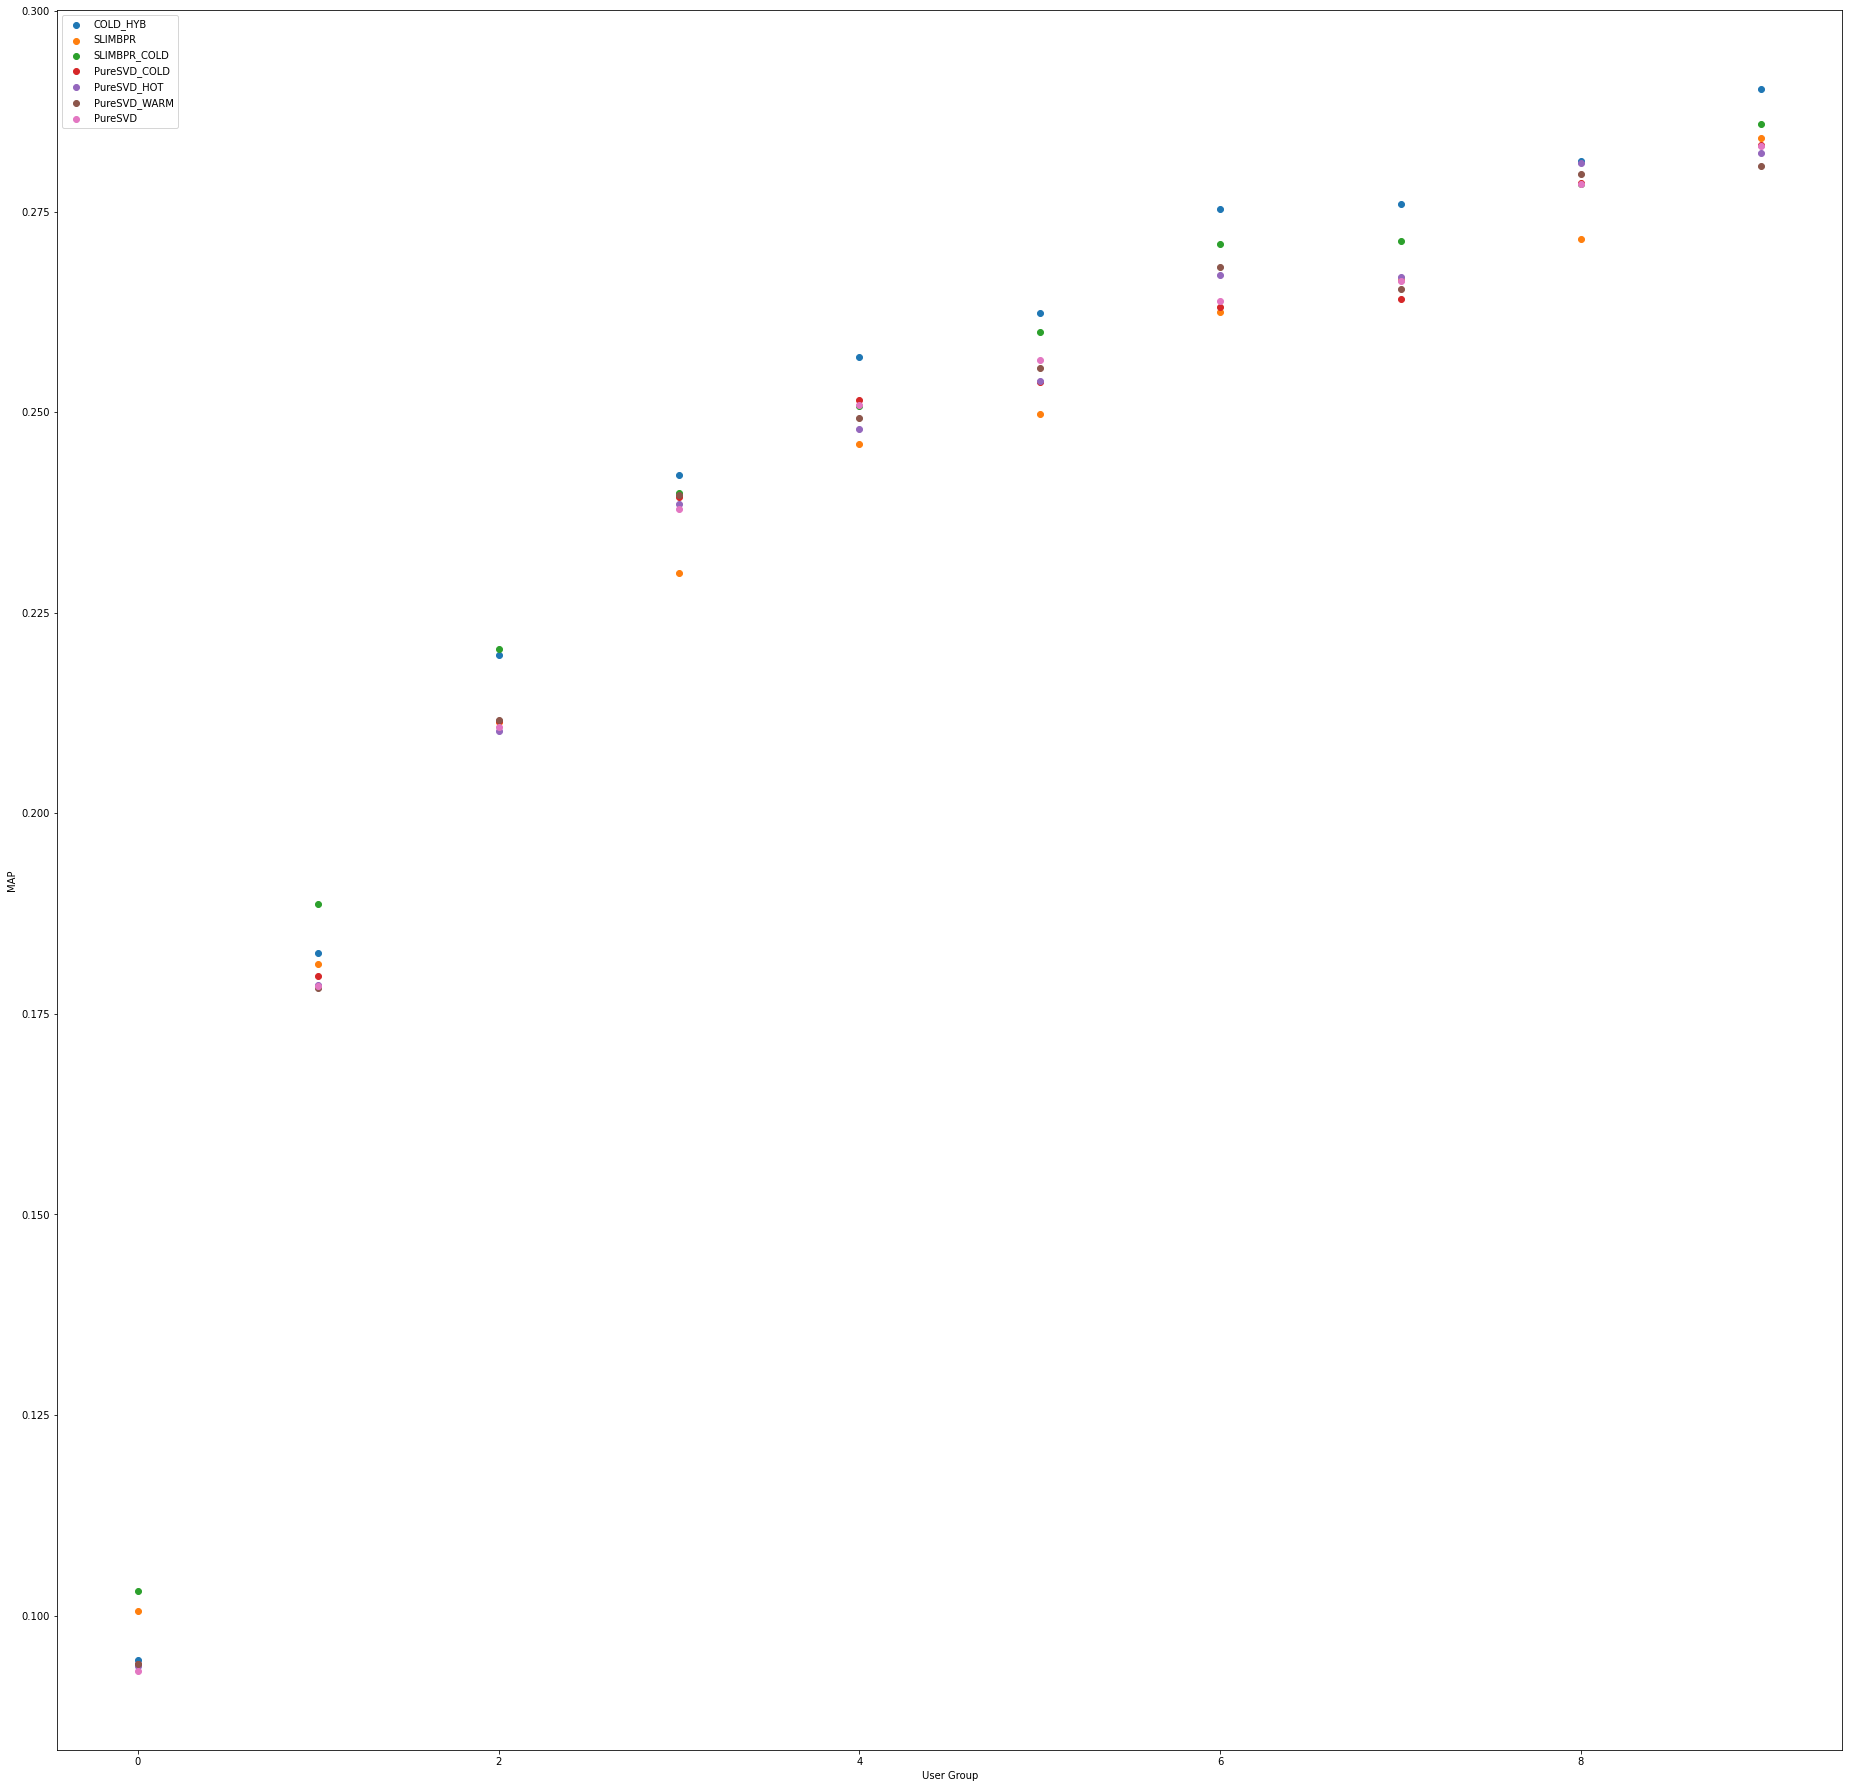

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline  

_ = plt.figure(figsize=(32, 32))
for label, recommender in recommenders:
    results = MAP_recommender_per_group[label]
    plt.scatter(x=np.arange(0,len(results)), y=results, label=label)
plt.ylabel('MAP')
plt.xlabel('User Group')
plt.legend()
plt.show()